In [2]:
%autoreload 2
%load_ext Cython

In [3]:
from collections import OrderedDict
import cPickle as pickle
import os
from os.path import abspath, dirname

os.sys.path.append(dirname(dirname(abspath('__file__'))))
from retro import (powerspace, spherical_volume, extract_photon_info,
                   shift_and_bin, pol2cart, sph2cart)

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [4]:
%%cython --annotate

cimport cython

from libc.math cimport ceil, floor, sqrt, cos, sin

import numpy as np
cimport numpy as np


@cython.embedsignature(True)
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
@cython.nonecheck(False)
cpdef sphbin2cartbin(double r_max, double r_power,
                     int n_rbins, int n_thetabins, int n_phibins,
                     double x_bw, double y_bw, double z_bw,
                     int x_oversample, int y_oversample,
                     int z_oversample,
                     int antialias_factor=1):
    """
    Parameters
    ----------
    r_max : double
        Maximum r bin edge (note that r binning is assumed to start at 0)
        
    r_power : double
        Power used for regular power-law binning in radius
        
    n_rbins, n_thetabins, n_phibins : int with n_thetabins % 2 == 0 and n_phibins % 4 == 0
        Number or r, theta, and phi bins; note that while there are no phi
        bins expected in the retro tables, `n_phi` is used for binning
        up any spherical cells that did not catch at least one Cartesian
        bin. Note also that both n_thetabins and n_phibins must be even
        and refer to the entire range of theta and phi, even though we
        only work with the first octant. Therefore, we require each of these
        to define cells that fit exactly within the first octant:
        n_thetabins must be even, while n_phibins must be an integer multiple
        of 4.

    x_bw, y_bw, z_bw : double
        Cartesian binwidths in x, y, and z directions

    x_oversample, y_oversample, z_oversample : int >= 1
        Oversmapling factors. If oversampling is used, the returned indices
        array will have floating point values. E.g., a bin index with
        oversampling of 2 could have take values 0, 0.5, 1, ...
        Note that this increases the computational cost _and_ increases the
        memory footprint of the produced array(s).

    antialias_factor : int from 1 to 50
        The smallest binning unit in each dimension is divided again by
        this factor for more accruately computing the volume of overlap
        (and then the sub-binning for antialiasing is discarded). This
        therefore does not add to the memory footprint, but will increase
        the computational cost.

    Returns
    -------
    ind_arrays : list of M numpy.ndarrays each of shape (N, 3), dtype float32
        One array per spherical bin in the first octant.

    vol_arrays : list of M numpy.ndarrays each of shape (N,), dtype float32
        One array per spherical bin

    """
    DEF MAX_AA_FACTOR = 50
    
    DEF PI = 3.1415926535897932384626433827
    DEF TWO_PI = 6.2831853071795862319959269371
    DEF PI_BY_2 = 1.5707963267948965579989817343
    
    assert n_rbins >= 1 and n_thetabins >= 1 and n_phibins >= 1
    assert n_thetabins % 2 == 0, 'A theta bin straddles XY-plane since `n_thetabins` is not even'
    assert n_phibins % 4 == 0, 'Phi bins straddle YZ-plane since `n_phibins` is not evenly divisible by 4'
    assert x_oversample >= 1 and y_oversample >= 1 and z_oversample >= 1
    assert 1 <= antialias_factor <= MAX_AA_FACTOR
    
    # Logic below about extrapolating from first octant to other octants 
    # fails if bin widths are different in different dimensions
    assert x_bw == y_bw == z_bw
    assert x_oversample == y_oversample == z_oversample
    
    cdef:
        int n_quadrant_thetabins = int(ceil(<double>n_thetabins / 2.0))
    
        double x_os_dbl = <double>x_oversample
        double y_os_dbl = <double>y_oversample
        double z_os_dbl = <double>z_oversample
    
        double x_bw_os = x_bw / x_os_dbl
        double y_bw_os = y_bw / y_os_dbl
        double z_bw_os = z_bw / z_os_dbl

        double x_bw_os_aa = x_bw_os / <double>antialias_factor
        double y_bw_os_aa = y_bw_os / <double>antialias_factor
        double z_bw_os_aa = z_bw_os / <double>antialias_factor

        double aa_vol = x_bw_os_aa * y_bw_os_aa * z_bw_os_aa
        double overlap_vol
    
        double x_halfbw_os_aa = x_bw_os_aa / 2.0
        double y_halfbw_os_aa = y_bw_os_aa / 2.0
        double z_halfbw_os_aa = z_bw_os_aa / 2.0

        int n_xbins_oct_os = <int>ceil(r_max / x_bw_os)
        int n_ybins_oct_os = <int>ceil(r_max / y_bw_os)
        int n_zbins_oct_os = <int>ceil(r_max / z_bw_os)

        int n_xbins_oct_os_aa = <int>ceil(r_max / x_bw_os_aa)
        int n_ybins_oct_os_aa = <int>ceil(r_max / y_bw_os_aa)
        int n_zbins_oct_os_aa = <int>ceil(r_max / z_bw_os_aa)

        double x_idx_mirror_pt = -1.0 / x_oversample
        double y_idx_mirror_pt = -1.0 / y_oversample
        double z_idx_mirror_pt = -1.0 / z_oversample
    
        double inv_r_power = 1.0 / r_power
        double power_r_bin_scale = <double>n_rbins / r_max**inv_r_power
        double costheta_bin_scale = <double>n_thetabins / 2.0
        double dphi = TWO_PI / <double>n_phibins

        unsigned int x_os_idx, y_os_idx, z_os_idx, xi, yi, zi
        double x_idx, y_idx, z_idx
        int r_bin_idx, theta_bin_idx, flat_bin_idx
    
        double x0, y0, z0
    
        double x_centers_sq[MAX_AA_FACTOR]
        double rho_squares[MAX_AA_FACTOR][MAX_AA_FACTOR]
    
        double x_center, y_center, z_center, x_center_sq, y_center_sq,  z_center_sq
        double rho_sq

        double r
        double new_vol
    
        double[:] phi_bin_centers = np.linspace(
            start=TWO_PI / <double>n_phibins / 2.0,
            stop=PI_BY_2 - TWO_PI / <double>n_phibins / 2.0,
            num=n_phibins
        )
        
        dict d
        list bin_mapping = []
        tuple xyz_idx_q1
        list ind_arrays = []
        list vol_arrays = []
    
        double r_bmin, r_bmax, r_bcenter
        double costheta_bmin, costheta_bmax, costheta_bcenter
        double rho_center, phi_bin_center
    
        double total_tabulated_vol, sph_bin_vol
        double dr, dcostheta
    
    # Note: there is no phi dependence in the source tables
    
    for r_bin_idx in range(n_rbins):
        for theta_bin_idx in range(n_quadrant_thetabins):
            bin_mapping.append(dict())

    for x_os_idx in range(n_xbins_oct_os):
        x_idx = <double>x_os_idx / x_os_dbl
        x0 = x_os_idx * x_bw_os + x_halfbw_os_aa
        for xi in range(antialias_factor):
            x_center = x0 + xi * x_bw_os_aa
            x_center_sq = x_center * x_center
            x_centers_sq[xi] = x_center_sq

        for y_os_idx in range(n_ybins_oct_os):
            y_idx = <double>y_os_idx / y_os_dbl
            y0 = y_os_idx * y_bw_os + y_halfbw_os_aa
            for yi in range(antialias_factor):
                y_center = y0 + yi * y_bw_os_aa
                y_center_sq = y_center * y_center
                for xi in range(antialias_factor):
                    rho_squares[xi][yi] = x_centers_sq[xi] + y_center_sq

            for z_os_idx in range(n_zbins_oct_os):
                z_idx = <double>z_os_idx / z_os_dbl
                
                # NOTE: populating _only_ first octant values!
                xyz_idx_q1 = (x_idx, y_idx, z_idx)

                z0 = z_os_idx * z_bw_os + z_halfbw_os_aa
                for zi in range(antialias_factor):
                    z_center = z0 + zi * z_bw_os_aa
                    z_center_sq = z_center * z_center
                    for xi in range(antialias_factor):
                        for yi in range(antialias_factor):
                            r = sqrt(rho_squares[xi][yi] + z_center_sq)
                            if r < 0 or r >= r_max:
                                continue
                                
                            r_bin_idx = int(floor(r**inv_r_power * power_r_bin_scale))
                            theta_bin_idx = int((1.0 - z_center / r) * costheta_bin_scale)
                            if theta_bin_idx < 0 or theta_bin_idx >= n_thetabins:
                                continue
                                
                            d = bin_mapping[r_bin_idx + n_rbins*theta_bin_idx]
                            new_vol = aa_vol + d.get(xyz_idx_q1, 0.0)
                            d[xyz_idx_q1] = new_vol

    # Account for any spherical bins that were assigned no corresponding
    # Cartesian bins; otherwise, normalize total binned volume to be no larger
    # than that of each spherical volume element (dr and dtheta come
    # from the polar bin, while dphi is pi/2 since we only computed one
    # octant)
    for r_bin_idx in range(n_rbins):
        r_bmin = (<double>r_bin_idx / power_r_bin_scale)**r_power
        r_bmax = (<double>(r_bin_idx + 1) / power_r_bin_scale)**r_power
        dr = r_bmax - r_bmin

        for theta_bin_idx in range(n_quadrant_thetabins):
            costheta_bmin = 1 - theta_bin_idx / costheta_bin_scale
            costheta_bmax = 1 - (theta_bin_idx + 1) / costheta_bin_scale
            dcostheta = costheta_bmax - costheta_bmin

            d = bin_mapping[r_bin_idx + n_rbins*theta_bin_idx]

            # For spherical volume elements that don't have any assigned Cartesian bins,
            # find spherical element's center and locate it in a Cartesian bin
            if len(d) == 0:
                r_bcenter = (r_bmin + r_bmax) / 2.0
                costheta_bcenter = (costheta_bmin + costheta_bmax) / 2.0
                z_center = r_bcenter * costheta_bcenter
                z_idx = floor(z_center / z_bw_os) / z_os_dbl
                rho_center = sqrt(r_bcenter**2 - z_center**2)
                sph_bin_vol = -dcostheta * (r_bmax**3 - r_bmin**3) / 3.0 * dphi

                for phi_idx in range(n_phibins):
                    phi_bin_center = phi_bin_centers[phi_idx]
                    x_center = rho_center * cos(phi_bin_center)
                    y_center = rho_center * sin(phi_bin_center)
                    
                    x_idx = floor(x_center / x_bw_os) / x_os_dbl
                    y_idx = floor(y_center / y_bw_os) / y_os_dbl
                    xyz_idx_q1 = (x_idx, y_idx, z_idx)
                    
                    # NOTE: duplicates are overwritten (i.e., should be at
                    # most one entry for xyz_idx_q1 per spherical bin)
                    d[xyz_idx_q1] = sph_bin_vol
            
            # Normalize volume weight assigned from this spherical element
            # to all associated Cartesian elements to be exactly the volume of the
            # spherical volume element (i.e., the area of the polar element rotated
            # through the first octant). We can assume this normalization to be correct
            # since we define the Cartesian binning to completely encapsulate the entire spherical
            # volume (so there won't be any "unbinned" parts of the spherical vol)
            sph_bin_vol = -dcostheta * (r_bmax**3 - r_bmin**3) / 3.0 * PI_BY_2
            vols = np.atleast_1d(d.values())
            total_tabulated_vol = np.sum(vols)
            norm_factor = sph_bin_vol / total_tabulated_vol
            vols *= norm_factor
                    
            ind_arrays.append(np.atleast_2d(np.array(d.keys(), dtype=np.float32)))
            vol_arrays.append(vols.astype(np.float32))

    return ind_arrays, vol_arrays

In [5]:
r_max = 400
r_power = 2
n_rbins = 200
n_thetabins = 40
n_phibins = 40

r_edges = powerspace(0, r_max, n_rbins + 1, r_power)
theta_edges = np.arccos(np.linspace(1, -1, n_thetabins + 1))

R, THETA = np.meshgrid(r_edges, theta_edges, indexing='ij')
coords = []
exact_vols = []
for ri in range(n_rbins):
    subcoords = []
    sub_exact_vols = []
    for ti in range(int(np.ceil(n_thetabins / 2.0))):
        rs = R[ri:ri+2, ti:ti+2]
        ts = THETA[ri:ri+2, ti:ti+2]
        bin_corner_coords = zip(rs.flat, ts.flat)
        dcostheta = np.abs(np.diff(np.cos([ts.max(), ts.min()])))
        exact_vol = spherical_volume(rmin=rs.max(), rmax=rs.min(), dcostheta=dcostheta, dphi=np.pi/2)
        sub_exact_vols.append(exact_vol)
    exact_vols.append(sub_exact_vols)
exact_vols = np.array(exact_vols)

In [6]:
#%%time

x_bw = y_bw = z_bw = 5
x_oversample = y_oversample = z_oversample = 2

kwargs = dict(
    r_max=r_max, r_power=r_power,
    n_rbins=n_rbins, n_thetabins=n_thetabins, n_phibins=n_phibins,
    x_bw=x_bw, y_bw=y_bw, z_bw=z_bw,
    x_oversample=x_oversample, y_oversample=y_oversample, z_oversample=z_oversample,
    antialias_factor=1
)
ind_arrays, vol_arrays = sphbin2cartbin(**kwargs)

In [79]:
%%time

dump_data = OrderedDict([('kwargs', kwargs), ('ind_arrays', ind_arrays), ('vol_arrays', vol_arrays)])
fname = (
    'sphbin2cartbin_first_octant_mapping'
    '_nr{n_rbins:d}_ntheta{n_thetabins:d}_nphi{n_phibins:d}'
    '_rmax{r_max:f}_rpwr{r_power}'
    '_xbw{x_bw:f}_ybw{y_bw:f}_zbw{z_bw:f}'
    '_xos{x_oversample:d}_yos{y_oversample:d}_zos{z_oversample:d}'
    '_aa{antialias_factor:d}'
    '.pkl'.format(**kwargs)
)
pickle.dump(dump_data, file(fname, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

!ls -hl {fname}

-rw-rw---- 1 justin icecube 34M Sep  3 22:37 sphbin2cartbin_first_octant_mapping_nr200_ntheta40_nphi40_rmax400.000000_rpwr2_xbw5.000000_ybw5.000000_zbw5.000000_xos2_yos2_zos2_aa1.pkl
CPU times: user 88 ms, sys: 44 ms, total: 132 ms
Wall time: 892 ms


In [7]:
binned_vol = np.sum([va.sum() for va in vol_arrays])
exact_vol = spherical_volume(rmin=0, rmax=r_max, dcostheta=-1, dphi=np.pi/2)
print 'exact vol = %f, binned vol = %f (%e fract error)' % (exact_vol, binned_vol, (binned_vol-exact_vol)/exact_vol)

exact vol = 33510321.638291, binned vol = 33510320.000000 (-4.888915e-08 fract error)


In [8]:
ind_bin_vols = np.array([va.sum() for va in vol_arrays])
fract_err = ind_bin_vols/exact_vols.flat - 1
abs_fract_err = np.abs(fract_err)
worst_abs_fract_err = np.max(abs_fract_err)
flat_idx = np.where(abs_fract_err == worst_abs_fract_err)[0][0]
r_idx, theta_idx = divmod(flat_idx, int(np.ceil(n_thetabins/2)))
print ('worst single-bin fract err: %e; r_idx=%d, theta_idx=%d; binned vol=%e, exact vol=%e'
       % (worst_abs_fract_err, r_idx, theta_idx, ind_bin_vols[flat_idx], exact_vols[r_idx, theta_idx]))

worst single-bin fract err: 3.575599e-07; r_idx=93, theta_idx=0; binned vol=1.122585e+03, exact vol=1.122585e+03


In [9]:
%%time

dom_depth_index = 49

geom = np.load('/home/justin/src/retro/retro/data/geo_array.npy')
dom_coords = geom[35, dom_depth_index:dom_depth_index+1, :]
dom_coords *= 0

photon_info, bin_edges = extract_photon_info(
    fpath='/data/icecube/retro_tables/full1000/retro_nevts1000_IC_DOM%d_r_cz_t_angles.fits' % dom_depth_index,
    dom_depth_index=dom_depth_index
)
#px = np.empty_like(photon_info.length)
#pz = np.empty_like(photon_info.length)
#pz = np.empty_like(photon_info.length)
#sph2cart(r=photon_info.length * np.cos(photon_info.deltaphi), theta=

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 16 ms


In [10]:
%%time

xlims = (-500, 500)
ylims = (-600, 600)
zlims = (-600, 600)

nx = int((xlims[1] - xlims[0]) / x_bw)
ny = int((ylims[1] - ylims[0]) / y_bw)
nz = int((zlims[1] - zlims[0]) / z_bw)

shape = (nx, ny, nz)

sp = photon_info.survival_prob[dom_depth_index]
plength = photon_info.length[dom_depth_index]
ptheta = photon_info.theta[dom_depth_index]
pdeltaphi = photon_info.deltaphi[dom_depth_index]

plength *= np.cos(pdeltaphi)
pz = plength * np.cos(ptheta)
prho = plength * np.sin(ptheta)

t_slice = [slice(None), slice(None), slice(None)]

t_indep_sp = 1 - np.prod(1 - sp[t_slice], axis=0)

mask = t_indep_sp != 0
scale = 1 / sp.sum(axis=0)[mask]

t_indep_pz = np.zeros_like(t_indep_sp)
t_indep_prho = np.zeros_like(t_indep_sp)

t_indep_pz[mask] = (pz[t_slice] * sp[t_slice]).sum(axis=0)[mask] * scale
t_indep_prho[mask] = (prho[t_slice] * sp[t_slice]).sum(axis=0)[mask] * scale

CPU times: user 96 ms, sys: 20 ms, total: 116 ms
Wall time: 117 ms


In [116]:
prho[t_slice].max()

0.99567038

In [24]:
from math import ceil, floor, sqrt, cos, sin, atan

import numpy as np


def bin_quantities(ind_arrays,
                   vol_arrays,
                   dom_coords,
                   survival_prob,
                   prho,
                   pz,
                   nr,
                   ntheta,
                   binned_spv,
                   binned_px_spv,
                   binned_py_spv,
                   binned_pz_spv,
                   binned_one_minus_sp,
                   nx,
                   ny,
                   nz,
                   x0,
                   y0,
                   z0,
                   xbw,
                   ybw,
                   zbw,
                   x_oversample,
                   y_oversample,
                   z_oversample):
    r"""Shift (r, theta) retro tables (i.e., (t, r, theta) tables with time
    marginalized out) to each DOM location and aggregate its quantities (with
    appropriate weighting) in (x, y, z) retro tables.

    Note that the results are aggregated in the input arrays (which are assumed
    to be appropriately instantiated), so there are no return values.

    The convention used is that DOMs are indexed by `i`, polar bins are indexed
    by `j` (flattened from 2D to 1D), and Cartesian bins are indexed by `k`
    (flattened from 3D to 1D). There are a total of `I` DOMs and each is
    assumed to have the same number of polar bins `J = J_r \times J_\theta`
    (where `J_r` and `J_\theta` are the numbers of bins in the radial and
    azimuthal directions, respectively). Each polar bin `j` maps to `K_j`
    Cartesian bins (n.b. this number can be different for each polar bin).

    There are a total of `N_x`, `N_y`, and `N_z` Cartesian bins in x-, y-, and
    z-directions, respectively.

    See Notes for more detailed description of the process carried out by this
    function.


    Parameters
    ----------
    ind_arrays : length-J list of shape (K_j, 3) numpy.ndarrays, dtype float32
        Each 3-element row contains the x-, y-, and z-coordinates of a
        Cartesian bin onto which the polar bin maps. There is one ind_array per
        polar bin in the first octant.

    vol_arrays : length-J list of shape (K_j,) numpy.ndarrays, dtype float32
        Volume from the polar bin to be applied to each of the N Cartesian
        bins. There is one vol_array per polar bin in the first octant.

    dom_coords : shape (I, 3) numpy.ndarray, dtype float32
        Each 3-element row represents a DOM x-, y, and z-coordinate at which to
        apply the photon info.

    survival_prob : shape (J_r, J_theta) numpy.ndarray, dtype float32
        Survival probability of a photon at this polar coordinate

    px, py, pz : shape (J_r, J_theta) numpy.ndarrays, dtype float32
        Average photon x-, y-, and z-components at this coordinate

    binned_spv : numpy.ndarray, same shape as `x`, `y`, and `z`
        Binned photon survival probabilities * volumes, accumulated for all
        DOMs to normalize the average surviving photon info (`binned_px_spv`,
        etc.) in the end

    binned_one_minus_sp : numpy.ndarray of shape (nx, ny, nz)
        Existing array to which ``1 - normed_survival_probability`` is
        multiplied (where the normalization factor is not infinite)

    binned_px_spv, binned_py_spv, binned_pz_spv : shape (nx, ny, nz) numpy.ndarray, dtype float64
        Existing arrays into which average photon components are accumulated

    nx, ny, nz : unsigned int
    x0, y0, z0 : float
    xbw, ybw, zbw : float
    x_oversample, y_oversample, z_oversample : unsigned int


    Notes
    -----
    For DOMs labeled `i`, each of which is characterized in polar bins `j`, we
    wish to find the "aggregated" survival probability `sp` and photon average
    behavior (`px`, `py`, and `pz`) in the Cartesian bins `k`.

    Weight survival probability by volume of overlap
        spv_{ijk} = sp_{ij} * v_{ijk}

    Weight average photon by volume of overlap times survival probability
        px_spv_{ijk} = px_{ij} * spv_{ijk}
        py_spv_{ijk} = py_{ij} * spv_{ijk}
        pz_spv_{ijk} = pz_{ij} * spv_{ijk}

    Total weighted survival probability for DOM `i`, Cartesian bin `k`
        spv_{ik} = \sum_j spv_{ijk}

    Normalization factor used for weighted survival probability contribution of
    DOM `i` to Cartesian bin `k' is just the sum of the overlap volumes.
        v_{ik} = \sum_j v_{ijk}

    Normalize survival probability weighted average before aggregating with
    other DOMs since, from DOM-to-DOM, this is _not_ a weighted average but
    rather a product (i.e., it's only a weighted average for polar bins that
    contribute to it for one DOM)
        sp_{ik} = spv_{ik} / v_{ik}

    Normalization factor for average photon; application of _this_ norm
    constant can be delayed until all DOM weighted avg photons have been
    aggregated since the final value is a simple weighted average. Note that
    only a single value in the following sum is added in this function, since it
        spv_k = \sum_i spv_{ik}

    In the end, one must compute the final survival probability and average
    photon in bin `k`. Note these operations are _not_ performed in this
    function since this function handles only a single type of DOM (i.e., a
    single source retro table, even if it is applied to multiple DOMs), and it
    is assumed that other types of DOMs must be aggregated before the final
    values are computed.
        sp_k = 1 - \prod_i (1 - sp_{ik})
        px_k = (1/spv_k) \cdot \sum_{ij} px_spv_{ijk}
        py_k = (1/spv_k) \cdot \sum_{ij} py_spv_{ijk}
        pz_k = (1/spv_k) \cdot \sum_{ij} pz_spv_{ijk}

    Identifying each `k` given a DOM `i` and polar bin `j` entails shifting
    (and possibly negating and/or swapping) the pre-calculated first-octant
    polar-to-Cartesian indices mapping (which assume they're centered at the
    origin) by the location of the DOM. The negation and/or swapping is
    performed to map to octants other than the first. The pre-calculated
    indices mapping is found in `sphbin2cartbin.ipynb`.

    See Also
    --------
    sphbin2cartbin.ipynb
        Computes the mapping from each polar bin in the first octant to the
        indices of the Cartesian bins it overlaps and volume of overlap, and
        stores these to disk for use by this function.

    """
    PI = 3.1415926535897932384626433827
    TWO_PI = 6.2831853071795862319959269371
    PI_BY_2 = 1.5707963267948965579989817343

    # Logic below about extrapolating from first octant to other octants fails
    # if bin widths are different sizes in different dimensions
    assert xbw == ybw == zbw
    assert x_oversample == y_oversample == z_oversample

    vol_mask = np.zeros((nx, ny, nz), dtype=np.uint32)
    binned_vol = np.zeros((nx, ny, nz), dtype=np.float64)
    #double[:, :, :] spv = np.zeros((nx, ny, nz), dtype=np.float64)
    num_first_octant_pol_bins = len(vol_arrays)
    num_cart_bins = nx * ny * nz

    x_half_os_bw = xbw / (2 * x_oversample)
    y_half_os_bw = ybw / (2 * y_oversample)
    z_half_os_bw = zbw / (2 * z_oversample)

    x_mirror_pt = -1.0 / x_oversample
    y_mirror_pt = -1.0 / y_oversample
    z_mirror_pt = -1.0 / z_oversample

    num_cart_bins_in_pol_bin = np.empty(num_first_octant_pol_bins, dtype=np.uint32)
    
    assert num_first_octant_pol_bins == nr * ntheta / 2

    for ix in range(num_first_octant_pol_bins):
        num_cart_bins_in_pol_bin[ix] = vol_arrays[ix].shape[0]

    failed_x, failed_y, failed_z = (0,)*3
    
    for (dom_x, dom_y, dom_z) in dom_coords:
        dom_x_float_idx = (dom_x - x0) / xbw
        dom_y_float_idx = (dom_y - y0) / ybw
        dom_z_float_idx = (dom_z - z0) / zbw
        for r_idx in range(nr):
            for theta_idx in range(int(ntheta / 2)): #flat_pol_idx in range(num_first_octant_pol_bins):
                flat_pol_idx = r_idx + nr * theta_idx

                ind_array = ind_arrays[flat_pol_idx]
                vol_array = vol_arrays[flat_pol_idx]

                for ix in range(num_cart_bins_in_pol_bin[flat_pol_idx]):
                    vol = vol_array[ix]
                    x_float_idx, y_float_idx, z_float_idx = ind_array[ix, :]

                    x = x_float_idx * xbw + x_half_os_bw
                    y = y_float_idx * ybw + y_half_os_bw
                    bin_pos_rho_norm = 1 / sqrt(x*x + y*y)
                    x *= bin_pos_rho_norm
                    y *= bin_pos_rho_norm

                    for hemisphere in range(2):
                        if hemisphere == 0:
                            z_idx = int(floor(z_float_idx + dom_z_float_idx))
                            theta_idx_ = theta_idx
                        else:
                            z_idx = int(floor(z_mirror_pt - z_float_idx + dom_z_float_idx))
                            theta_idx_ = ntheta - 1 - theta_idx

                        if z_idx < 0 or z_idx >= nz:
                            failed_z += 1
                            continue

                        sp = survival_prob[r_idx][theta_idx_]
                        spv = sp * vol
                        prho_ = prho[r_idx][theta_idx_]
                        pz_ = pz[r_idx][theta_idx_]

                        px_nom = x * prho_ 
                        py_nom = y * prho_ 

                        for quadrant in range(4):
                            if quadrant == 0:
                                x_idx = int(floor(x_float_idx + dom_x_float_idx))
                                y_idx = int(floor(y_float_idx + dom_y_float_idx))
                                px_ = px_nom
                                py_ = py_nom

                            # x -> +y, y -> -x
                            elif quadrant == 1:
                                x_idx = int(floor(y_mirror_pt - y_float_idx + dom_x_float_idx))
                                y_idx = int(floor(x_float_idx + dom_y_float_idx))
                                px_ = -py_nom
                                py_ = px_nom

                            # x -> -x, y -> -y
                            elif quadrant == 2:
                                x_idx = int(floor(x_mirror_pt - x_float_idx + dom_x_float_idx))
                                y_idx = int(floor(y_mirror_pt - y_float_idx + dom_y_float_idx))
                                px_ = -px_nom
                                py_ = -py_nom

                            # x -> -y, y -> x
                            elif quadrant == 3:
                                x_idx = int(floor(y_float_idx + dom_x_float_idx))
                                y_idx = int(floor(x_mirror_pt - x_float_idx + dom_y_float_idx))
                                px_ = py_nom
                                py_ = -px_nom

                            if x_idx < 0 or x_idx >= nx:
                                failed_x += 1
                                continue
                                
                            if y_idx < 0 or y_idx >= ny:
                                failed_y += 1
                                continue

                            vol_mask[x_idx][y_idx][z_idx] = 1
                            binned_vol[x_idx][y_idx][z_idx] += vol
                            binned_spv[x_idx][y_idx][z_idx] += spv
                            binned_px_spv[x_idx][y_idx][z_idx] += px_ * spv
                            binned_py_spv[x_idx][y_idx][z_idx] += py_ * spv
                            binned_pz_spv[x_idx][y_idx][z_idx] += pz_ * spv

        print('failed_x:', failed_x, 'failed_y:', failed_y, 'failed_z:', failed_z)
        # Normalize the weighted sum of survival probabilities for this DOM and
        # then include it in the overall survival probability via probabilistic
        # "or" statement:
        #     P(A) or P(B) = 1 - (1 - P(A)) * (1 - P(B))
        # though we stop at just the two factors on the right and more
        # probabilities can be easily combined before being subtracted form one
        # to yield the overall probability.
        for x_idx in range(nx): #, nogil=True, schedule='guided'):
            for y_idx in range(ny):
                for z_idx in range(nz):
                    if vol_mask[x_idx][y_idx][z_idx] == 0:
                        continue
                    binned_one_minus_sp[x_idx][y_idx][z_idx] *= (
                        1 - binned_spv[x_idx][y_idx][z_idx] / binned_vol[x_idx][y_idx][z_idx]
                    )

In [11]:
#%%time

binned_spv = np.zeros((shape), dtype=np.float64)
binned_px_spv = np.zeros((shape), dtype=np.float64)
binned_py_spv = np.zeros((shape), dtype=np.float64)
binned_pz_spv = np.zeros((shape), dtype=np.float64)
binned_one_minus_sp = np.ones((shape), dtype=np.float64)

bin_quantities(
    ind_arrays,
    vol_arrays,
    dom_coords,
    t_indep_sp,
    t_indep_prho,
    t_indep_pz,
    n_rbins,
    n_thetabins,
    binned_spv,
    binned_px_spv,
    binned_py_spv,
    binned_pz_spv,
    binned_one_minus_sp,
    nx,
    ny,
    nz,
    xlims[0],
    ylims[0],
    zlims[0],
    x_bw,
    y_bw,
    z_bw,
    x_oversample,
    y_oversample,
    z_oversample
)
print(np.sum(binned_one_minus_sp > 0))

NameError: name 'bin_quantities' is not defined

In [27]:
mask = binned_spv != 0
print((binned_px_spv[mask] / binned_spv[mask]).max())

1.62759017628


In [12]:
#%%time

binned_spv = np.zeros((shape), dtype=np.float64)
binned_px_spv = np.zeros((shape), dtype=np.float64)
binned_py_spv = np.zeros((shape), dtype=np.float64)
binned_pz_spv = np.zeros((shape), dtype=np.float64)
binned_one_minus_sp = np.ones((shape), dtype=np.float64)

shift_and_bin.bin_quantities(
    ind_arrays,
    vol_arrays,
    dom_coords,
    t_indep_sp,
    t_indep_prho,
    t_indep_pz,
    n_rbins,
    n_thetabins,
    binned_spv,
    binned_px_spv,
    binned_py_spv,
    binned_pz_spv,
    binned_one_minus_sp,
    nx,
    ny,
    nz,
    xlims[0],
    ylims[0],
    zlims[0],
    x_bw,
    y_bw,
    z_bw,
    x_oversample,
    y_oversample,
    z_oversample
)

In [13]:
%%time

mask = binned_spv != 0
inv_spv = np.zeros_like(binned_spv)
inv_spv[mask] = 1 / binned_spv[mask]
binned_px = binned_px_spv * inv_spv
binned_py = binned_py_spv * inv_spv
binned_pz = binned_pz_spv * inv_spv

CPU times: user 100 ms, sys: 32 ms, total: 132 ms
Wall time: 133 ms


In [15]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/justin/.local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shape']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [131]:
binned_one_minus_sp.shape

(200, 240, 240)

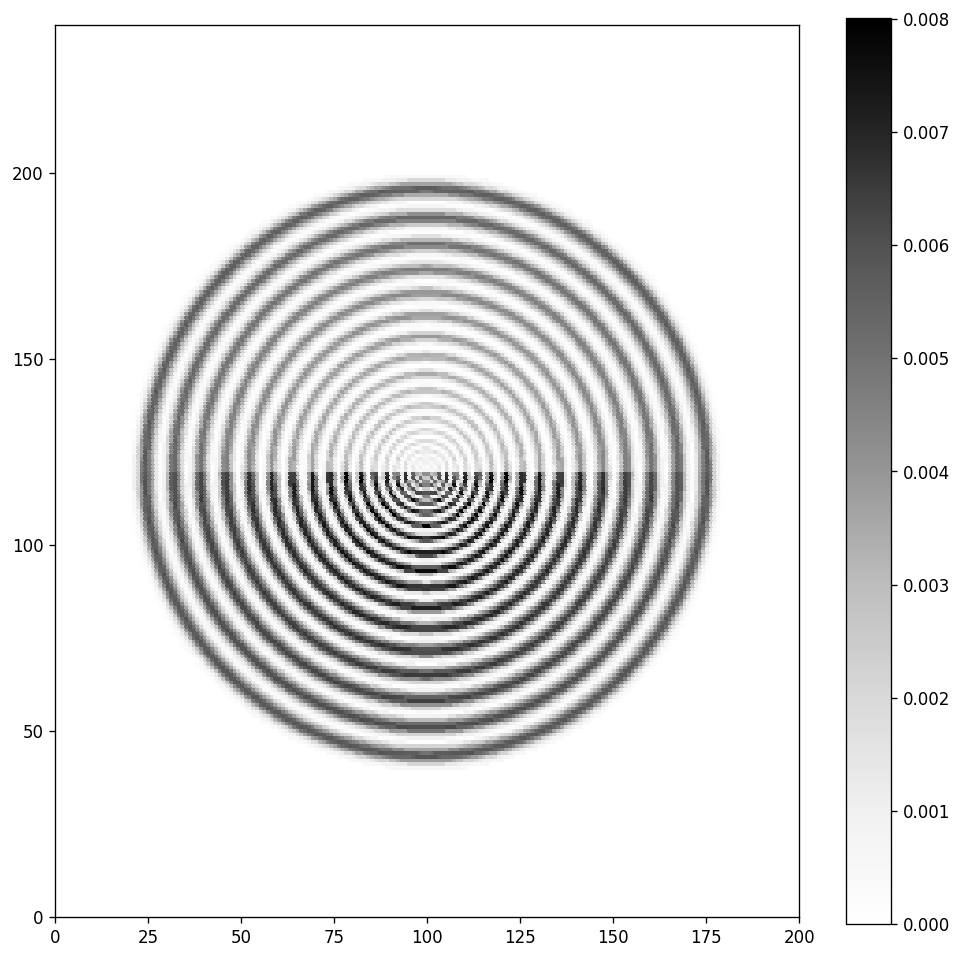

In [16]:
fig = plt.figure(1, figsize=(10, 10), dpi=120)
fig.clf()
ax = fig.add_subplot(111)
pcm = ax.pcolormesh((1 - binned_one_minus_sp)[:, 119, :].T,
                    cmap='Greys', edgecolors='face')
ax.axis('image')
plt.colorbar(pcm);

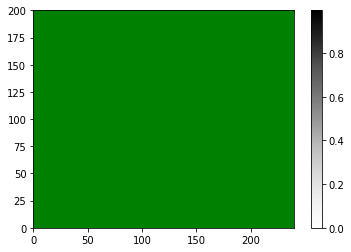

In [152]:
ax = pcolormesh((binned_px_spv * inv_spv).max(axis=2), cmap='Greys', edgecolors='g')
plt.axis('image')
plt.colorbar();

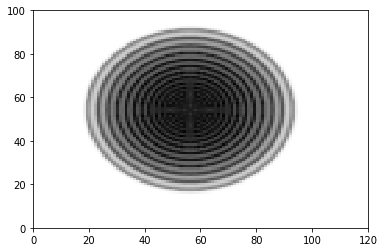

In [59]:
pcolor(binned_spv.sum(axis=2), cmap='Greys')

In [17]:
%pylab inline
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


(200, 40, 8000, 4000)
54


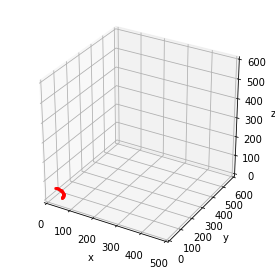

In [54]:
print(n_rbins, n_thetabins, n_rbins * n_thetabins, len(ind_arrays))
r_idx = 160
theta_idx = 5
flat_idx = r_idx + n_rbins * theta_idx
#flat_idx = theta_idx + r_idx * n_thetabins
flat_idx = 1000+650
ind_array = ind_arrays[flat_idx]
print(ind_array.shape[0])

fig = plt.figure(1, figsize=(10, 10))
fig.clf()
ax = fig.add_subplot(221, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(0, xlims[1])
ax.set_ylim(0, ylims[1])
ax.set_zlim(0, zlims[1])
ax.grid(True)
#ax.axis('square')
ax.plot((ind_array[:,0] + 1/2/x_oversample)*x_bw,
        (ind_array[:,1] + 1/2/y_oversample)*y_bw,
        (ind_array[:,2] + 1/2/z_oversample)*z_bw,
        alpha=0.5, marker='o', ms=2, c='r', linestyle='none')

In [162]:
np.where(r_edges == 100)

(array([100]),)